In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, ConfusionMatrixDisplay

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import TensorDataset, DataLoader
import math

In [23]:
torch.version.cuda

In [24]:
org_df = pd.read_csv('C:\\Users\\jspan\\Downloads\\STAT 5243\\5243 Project\\data-society-bank-marketing-data\\bank-additional-full.csv', delimiter=';')

In [25]:
no_dup = org_df.drop_duplicates()

In [26]:
no_dup.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [27]:
shorten = no_dup.drop(['month', 'day_of_week'], axis = 1)

In [28]:
shorten['y'] = shorten['y'].map({'yes':1, 'no':0})
df = shorten.copy()
X = df.drop('y', axis = 1)
Y = df['y']

In [29]:
labels = ['no contant', 'less then 3 month', 'among 3 month to a year', 'more than a year']
bins = [-np.inf, -1, 120, 365, np.inf]
binned = pd.cut(X['pdays'], bins, labels = labels)
df_binned = pd.get_dummies(binned, prefix = 'pdays')
X = X.drop('pdays', axis = 1)


In [30]:
categorical = X.select_dtypes(include=['object']).columns
numerical = X.select_dtypes(include=['int64','float64']).columns

In [31]:
numerical

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [32]:
encoded = pd.get_dummies(X, columns=categorical)
encoded = encoded.select_dtypes(include='bool').astype(int)
X = pd.concat([X[numerical], encoded], axis = 1)

In [33]:
X = X.join(df_binned)

In [34]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X[numerical])
scaled_numerical_df = pd.DataFrame(scaled_numerical, index=X.index, columns=numerical)
X.update(scaled_numerical_df)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(32940, 51) (32940,) (8236, 51) (8236,)


In [36]:
print('Original dataset shape %s' % Counter(y_train))

# Resample the dataset
ros = RandomOverSampler(sampling_strategy={1:15000})
X_train, y_train = ros.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 29268, 1: 3672})
Resampled dataset shape Counter({0: 29268, 1: 15000})


In [41]:
class MLP(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()

        self.layer1 = nn.Linear(input_shape, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.layer4 = nn.Linear(32, output_shape)

        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(p=0.3)

        self.init_weights()

    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.leaky_relu(self.layer3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.layer4(x))
        return x
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.uniform_(m.weight, -5, 5)
                init.constant_(m.bias, 0)



In [47]:
def model_train(X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate, decay):

    input_shape = X_train.shape[1]
    output_shape = 1
    model = MLP(input_shape, output_shape)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = decay)
    criterion = nn.BCELoss()

    X_train_tensor = torch.tensor(X_train.astype('float32').values)
    y_train_tensor = torch.tensor(y_train.astype('float32').values).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test.astype('float32').values)
    y_test_tensor = torch.tensor(y_test.astype('float32').values).reshape(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    validation_accuracy = []
    train_accuracy = []
    validation_F1_lst = []
    validation_recall_lst = []
    validation_precision_lst = []

    for epoch in range(epochs):
        model.train()

        correct = 0
        total = 0

        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets) # Compute the loss
            predicted = outputs.round()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss.backward() # Backward pass
            optimizer.step() # Update the weights

        train_acc = correct / total
        train_accuracy.append(train_acc)

        # Validation loop
        model.eval()
        validation_loss = 0
        correct = 0
        total = 0
        test_output = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                with torch.no_grad():
                    outputs = model(inputs) # Forward pass
                    test_output.extend(outputs.detach().cpu().numpy())
                    loss = criterion(outputs, targets) # Compute the loss
                    validation_loss += loss.item()
                    predicted = outputs.round()
                    total += targets.size(0)
                    correct += (predicted == targets).sum().item()

        validation_loss /= len(test_loader)
        validation_acc = correct/total

        validation_accuracy.append(validation_acc)
        
        validation_f1 = f1_score(y_test, np.round(test_output))
        validation_recall = recall_score(y_test, np.round(test_output))
        validation_precision = precision_score(y_test, np.round(test_output))

        validation_F1_lst.append(validation_f1)
        validation_recall_lst.append(validation_recall)
        validation_precision_lst.append(validation_precision)

        print(f"Epoch {epoch+1}/{epochs},"
              f"Validation Loss: {validation_loss:.4f},"
              f"Train Accuracy: {train_acc:.4f}, "
              f"Validation Accuracy: {validation_acc:.4f},"
              f"validation f1: {validation_f1:.4f},"
              f"validation recall: {validation_recall:.4f}")
        
    num = range(1, len(validation_accuracy)+1)
    plt.plot(num, validation_accuracy, ":", label = "validation accuracy")
    plt.plot(num, train_accuracy, ":", label = "train accuracy")
    plt.plot(num, validation_recall_lst, label = "validation recall score")
    plt.plot(num, validation_F1_lst, label = "validation F1 score")
    plt.xlabel("Epoch")
    plt.ylabel('value')
    plt.legend(loc = 'lower right')
    plt.plot()

    res_dict = {
        'validation accuracy': validation_accuracy,
        'validation F1 score': validation_F1_lst,
        'validation recall score': validation_recall_lst,
        'validation precision score': validation_precision_lst
    }

    # pd.set_option('display.max_rows', None)
    result_df = pd.DataFrame.from_dict(res_dict)
    result_df.index = result_df.index + 1
    display(result_df)

    ConfusionMatrixDisplay.from_predictions(y_test, np.round(test_output))

Epoch 1/100,Validation Loss: 2.3519,Train Accuracy: 0.5268, Validation Accuracy: 0.7165,validation f1: 0.2673,validation recall: 0.4405
Epoch 2/100,Validation Loss: 1.5793,Train Accuracy: 0.6032, Validation Accuracy: 0.8347,validation f1: 0.4294,validation recall: 0.5295
Epoch 3/100,Validation Loss: 1.8479,Train Accuracy: 0.6527, Validation Accuracy: 0.8465,validation f1: 0.4746,validation recall: 0.5905
Epoch 4/100,Validation Loss: 1.6127,Train Accuracy: 0.6841, Validation Accuracy: 0.8641,validation f1: 0.5183,validation recall: 0.6225
Epoch 5/100,Validation Loss: 1.6568,Train Accuracy: 0.7053, Validation Accuracy: 0.8626,validation f1: 0.5417,validation recall: 0.6918
Epoch 6/100,Validation Loss: 1.5984,Train Accuracy: 0.7214, Validation Accuracy: 0.8635,validation f1: 0.5504,validation recall: 0.7115
Epoch 7/100,Validation Loss: 1.1606,Train Accuracy: 0.7346, Validation Accuracy: 0.8792,validation f1: 0.5746,validation recall: 0.6949
Epoch 8/100,Validation Loss: 0.9418,Train Accura

,validation accuracy,validation F1 score,validation recall score,validation precision score
1,0.716489,0.267336,0.440538,0.191892
2,0.834750,0.429350,0.529473,0.361072
3,0.846527,0.474647,0.590486,0.396803
4,0.864133,0.518295,0.622544,0.443953
5,0.862555,0.541700,0.691830,0.445110
6,0.863526,0.550400,0.711479,0.448793
7,0.879189,0.574605,0.694933,0.489796
8,0.878703,0.578303,0.708376,0.488588
9,0.873968,0.581114,0.744571,0.476506
10,0.874332,0.580802,0.741468,0.477364


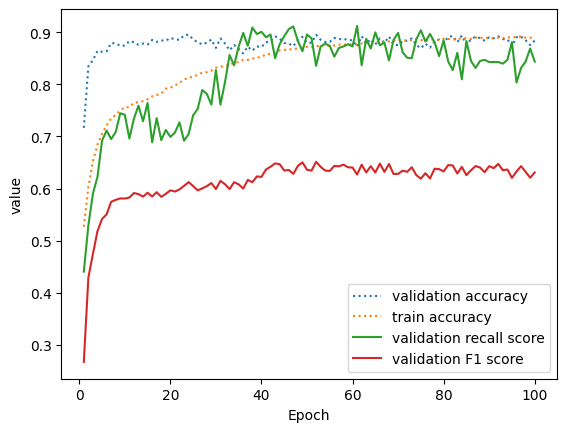

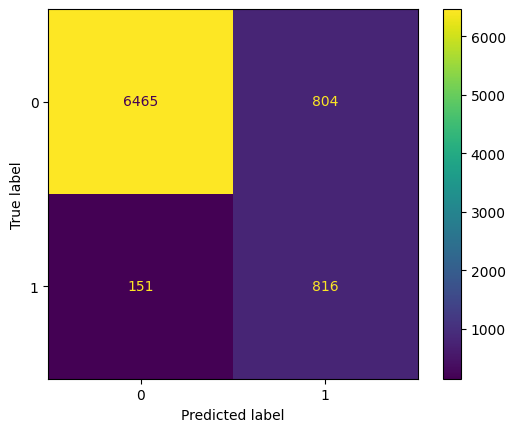

In [48]:
model_train(X_train, y_train, X_test, y_test, 100, 32, 0.0001, 0.005)